In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('Fraud.csv')

In [ ]:
df.head(5)

In [4]:
len(df)

6362620

In [5]:
df.columns = [x.lower() for x in df.columns]

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = df.drop(columns = ['isfraud'] , axis = 'columns')
y = df['isfraud']

In [8]:
X_train, X_test,y_train,y_test = train_test_split(X ,y , stratify = y , test_size = 0.4)

In [9]:
X_val, X_test,y_val,y_test = train_test_split(X_test ,y_test , stratify = y_test , test_size = 0.5)

In [10]:
y_train.mean() , y_val.mean() , y_test.mean()

(0.001290872837499856, 0.0012903489443028186, 0.0012911347840983745)

In [11]:
y_train.value_counts() , y_val.value_counts() , y_test.value_counts()

(0    3812644
 1       4928
 Name: isfraud, dtype: int64,
 0    1270882
 1       1642
 Name: isfraud, dtype: int64,
 0    1270881
 1       1643
 Name: isfraud, dtype: int64)

There is severe data imbalance where 0.1% of the transactions are fraudulent

### EDA on train data

In [63]:
df_train = X_train
df_train['isfraud'] = y_train

In [182]:
df_val = X_val
df_val['isfraud'] = y_val

df_test = X_test
df_test['isfraud'] = y_test

In [65]:
for column in df_train.columns:
    if df_train[column].dtype == object:
        print('------------------------------')
        print(f'column : {column}')
        print('------------------------------')
        print(df_train[column].value_counts())

------------------------------
column : type
------------------------------
CASH_OUT    1342070
PAYMENT     1290839
CASH_IN      839742
TRANSFER     320080
DEBIT         24841
Name: type, dtype: int64
------------------------------
column : nameorig
------------------------------
C1832548028    3
C400299098     3
C1462946854    3
C1739646194    2
C47806046      2
              ..
C2064357198    1
C945253856     1
C1383109984    1
C2021449413    1
C1230174815    1
Name: nameorig, Length: 3814250, dtype: int64
------------------------------
column : namedest
------------------------------
C1590550415    69
C1286084959    66
C998351292     62
C1262822392    62
C1899073220    60
               ..
C1264364533     1
M1196741474     1
M980016277      1
M840165478      1
M1917855397     1
Name: namedest, Length: 1799458, dtype: int64


In [68]:
mask1 = df_train['isfraud'] == 1

test = df_train[mask]['namedest'].value_counts().reset_index()

C:\Users\YuanAnaconda\AppData\Local\Temp\ipykernel_9620\4030031459.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test = df_train[mask]['namedest'].value_counts().reset_index()


In [69]:
mask = test['namedest'] > 1
test[mask]['namedest'].sum()

24

1. <1% of the fraudulent transactions were sent to the same account.
2. Due to it's high-cardinality, we shall remove it from our model as it does not help identify transactions that are fraudulent

In [70]:
mask = df_train['isfraud'] == 1
test = df_train[mask]['nameorig'].value_counts().reset_index()
mask = test['nameorig'] > 1
test[mask]['nameorig'].sum()

0

1. None of the transactions that are fraudulent occured from the same account.
2. Thus we shall exclude this column from our model as well

In [71]:
mask = df_train['isfraud'] == 1
test = df_train[mask]['type'].value_counts()
test

CASH_OUT    2499
TRANSFER    2429
Name: type, dtype: int64

In [73]:
print('----------------------------------------')
print('transaction proportion in percentages')
print('----------------------------------------')
print(df_train['type'].value_counts(normalize = True))
print('----------------------------------------')
print('transaction counts')
print('----------------------------------------')
print(df_train['type'].value_counts())

----------------------------------------
transaction proportion in percentages
----------------------------------------
CASH_OUT    0.351551
PAYMENT     0.338131
CASH_IN     0.219968
TRANSFER    0.083844
DEBIT       0.006507
Name: type, dtype: float64
----------------------------------------
transaction counts
----------------------------------------
CASH_OUT    1342070
PAYMENT     1290839
CASH_IN      839742
TRANSFER     320080
DEBIT         24841
Name: type, dtype: int64


1. Even though only 8% of all transactions are "transfer" about 1/2 of all fraudulent activities are 'transfer' type
2. The other half of all fraudulent transactions are "cashout" type

### Base line model

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

In [165]:
X_train.drop(columns = ['namedest','nameorig'] , axis='columns' , inplace = True)
X_val.drop(columns = ['namedest','nameorig'] , axis='columns' , inplace = True)
X_test.drop(columns = ['namedest','nameorig'] , axis='columns' , inplace = True)

In [77]:
ct = make_column_transformer((OneHotEncoder(),make_column_selector(dtype_include = object)))

In [78]:
clf = LogisticRegression(class_weight = 'balanced' , solver = 'saga' , tol = 1e-3 , max_iter = 1000)
pipeline = make_pipeline(ct,clf)

In [79]:
pipeline.fit(X_train,y_train)

C:\Users\YuanAnaconda\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DA7857E910>)])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='saga', tol=0.001))])

In [82]:
pipeline.score(X_train,y_train)

0.9161377964842575

In [87]:
from sklearn.metrics import confusion_matrix

In [168]:
y_pred = pipeline.predict(X_train)

In [99]:
from sklearn.metrics import ConfusionMatrixDisplay

In [167]:
confusion_matrix(y_train, y_pred)

array([[3494993,  317651],
       [   2499,    2429]], dtype=int64)

In [97]:
y_val_pred = pipeline.predict(X_val)

In [98]:
confusion_matrix(y_val, y_val_pred)

array([[1165313,  105569],
       [    804,     838]], dtype=int64)

In [105]:
import matplotlib.pyplot as plt

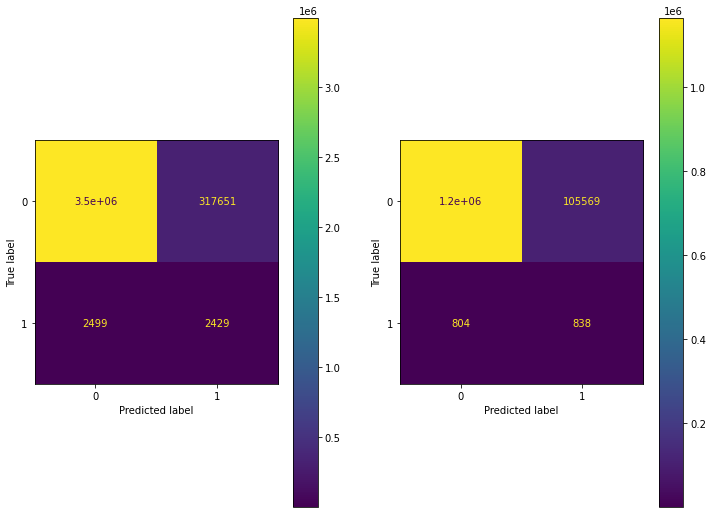

In [130]:
fig,ax = plt.subplots(1,2,figsize=(12,9))
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred)).plot(ax = ax[0])
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred)).plot(ax = ax[1])

In [132]:
df_train.head(5)

,step,type,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isflaggedfraud,is_fraud,isfraud
1012029,46,CASH_IN,301107.69,6354315.46,6655423.15,1446616.73,1145509.04,0,0,0
4146185,303,PAYMENT,45843.69,5534.00,0.00,0.00,0.00,0,0,0
3818653,281,PAYMENT,3274.46,33420.00,30145.54,0.00,0.00,0,0,0
766508,39,CASH_IN,223213.65,1046.00,224259.65,697023.59,473809.95,0,0,0
6054424,495,CASH_IN,87866.87,7755812.24,7843679.11,133608.05,45741.18,0,0,0


In [133]:
mask = df_train['is_fraud'] == 1
df_train[mask]

,step,type,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isflaggedfraud,is_fraud,isfraud
3188081,240,TRANSFER,248962.83,248962.83,0.0,0.00,0.00,0,1,1
6170520,563,CASH_OUT,96989.06,96989.06,0.0,1112486.16,1209475.22,0,1,1
2116097,183,TRANSFER,4354175.33,4354175.33,0.0,0.00,0.00,0,1,1
4023010,299,CASH_OUT,1158358.08,1158358.08,0.0,0.00,1158358.08,0,1,1
6050772,493,TRANSFER,605108.36,605108.36,0.0,0.00,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...
6027402,470,TRANSFER,120843.94,120843.94,0.0,0.00,0.00,0,1,1
5188051,367,CASH_OUT,48774.46,48774.46,0.0,0.00,48774.46,0,1,1
6272956,626,TRANSFER,55740.39,55740.39,0.0,0.00,0.00,0,1,1
6168677,557,TRANSFER,643052.88,643052.88,0.0,0.00,0.00,0,1,1


In [138]:
mask = df_train['oldbalancedest'] == 0
mask1 = df_train['is_fraud'] == 1
len(df_train[mask & mask1])/len(df_train[mask1])

0.6479301948051948

In [179]:
def flag1_function(df):
    x = df['oldbalancedest']
    df['flag1'] = df['oldbalancedest'].apply(lambda x : 1 if x == 0 else 0)
    return df

In [144]:
df_train['orgdelta'] = df_train['amount'] - df_train['oldbalanceorg']

In [154]:
mask = df_train['orgdelta'] == 0
mask1 = df_train['is_fraud'] == 1
df_train[mask & mask1]

,step,type,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isflaggedfraud,is_fraud,isfraud,flag1,orgdelta
3188081,240,TRANSFER,248962.83,248962.83,0.0,0.00,0.00,0,1,1,1,0.0
6170520,563,CASH_OUT,96989.06,96989.06,0.0,1112486.16,1209475.22,0,1,1,0,0.0
2116097,183,TRANSFER,4354175.33,4354175.33,0.0,0.00,0.00,0,1,1,1,0.0
4023010,299,CASH_OUT,1158358.08,1158358.08,0.0,0.00,1158358.08,0,1,1,1,0.0
6050772,493,TRANSFER,605108.36,605108.36,0.0,0.00,0.00,0,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6027402,470,TRANSFER,120843.94,120843.94,0.0,0.00,0.00,0,1,1,1,0.0
5188051,367,CASH_OUT,48774.46,48774.46,0.0,0.00,48774.46,0,1,1,1,0.0
6272956,626,TRANSFER,55740.39,55740.39,0.0,0.00,0.00,0,1,1,1,0.0
6168677,557,TRANSFER,643052.88,643052.88,0.0,0.00,0.00,0,1,1,1,0.0


In [295]:
mask2 = df_train['amount'] == 10_000_000
mask3 = df_train['amount'] < df_train['oldbalanceorg']
df_train[mask2 & mask3]['isfraud'].value_counts()

1    79
Name: isfraud, dtype: int64

1. all transactions that are exactly $10,000,000 and if the account has sufficient funds it'll be flagged as fraudulent

In [155]:
df_train['is_fraud'].sum()

4928

In [158]:
import numpy as np

In [163]:
def flag2_function(df):
    df['orgdelta'] = df['amount'] - df['oldbalanceorg']
    x = df['orgdelta']
    condlist = [x==0 , x!=0]
    choicelist = [1,0]
    df['flag2'] = np.select(condlist,choicelist)
    return df

In [265]:
def flag3_function(df):
    df['flag3'] = (df['amount'] < df['oldbalanceorg']) & (df['amount'] == 10_000_000)
    df['flag3'].astype('int').sum()
    return df

In [266]:
df_train = flag1_function(df_train)
df_val = flag1_function(df_val)
df_test = flag1_function(df_test)

df_train = flag2_function(df_train)
df_val = flag2_function(df_val)
df_test = flag2_function(df_test)

df_train = flag3_function(df_train)
df_val = flag3_function(df_val)
df_test = flag3_function(df_test)

### Model 2

In [174]:
def column_selector(df,x_columns,y_column):
    return df[x_columns] , df[y_column]

In [176]:
df_train.columns

Index(['step', 'type', 'amount', 'oldbalanceorg', 'newbalanceorig',
       'oldbalancedest', 'newbalancedest', 'isflaggedfraud', 'is_fraud',
       'isfraud', 'flag1', 'orgdelta', 'flag2'],
      dtype='object')

In [267]:
X_columns = ['flag2','flag3']

In [268]:
X_train , y_train = column_selector(df_train , X_columns , 'isfraud')
X_val , y_val = column_selector(df_val , X_columns , 'isfraud')
X_test , y_test = column_selector(df_test , X_columns , 'isfraud')

In [269]:
ct = make_column_transformer((OneHotEncoder(),make_column_selector(dtype_include = object)))
clf = LogisticRegression(class_weight = 'balanced' , solver = 'saga' , tol = 1e-3 , max_iter = 1000)
pipeline = make_pipeline(clf)
pipeline.fit(X_train,y_train)

Pipeline(steps=[('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='saga', tol=0.001))])

In [270]:
from sklearn.metrics import classification_report

In [271]:
pd.DataFrame(classification_report(pipeline.predict(X_train),y_train , output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000e+00,0.995739,0.999994,9.978693e-01,9.999945e-01
recall,9.999945e-01,1.000000,0.999994,9.999972e-01,9.999945e-01
f1-score,9.999972e-01,0.997865,0.999994,9.989310e-01,9.999945e-01
support,3.812665e+06,4907.000000,0.999994,3.817572e+06,3.817572e+06


In [272]:
def get_classification_report(pipeline,X,y):
    y_preds = pipeline.predict(X)
    return pd.DataFrame(classification_report(pipeline.predict(X_train),y_train , output_dict = True)) , y_preds

In [273]:
train_report , y_preds = get_classification_report(pipeline,X_train,y_train)

In [274]:
val_report , y_val_preds = get_classification_report(pipeline,X_val,y_val)
test_report , y_test_preds = get_classification_report(pipeline,X_test,y_test)

In [275]:
train_report

,0,1,accuracy,macro avg,weighted avg
precision,1.000000e+00,0.995739,0.999994,9.978693e-01,9.999945e-01
recall,9.999945e-01,1.000000,0.999994,9.999972e-01,9.999945e-01
f1-score,9.999972e-01,0.997865,0.999994,9.989310e-01,9.999945e-01
support,3.812665e+06,4907.000000,0.999994,3.817572e+06,3.817572e+06


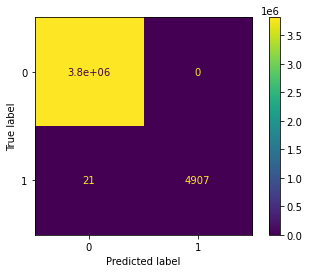

In [276]:
ConfusionMatrixDisplay(confusion_matrix(y_train,y_preds)).plot()

In [277]:
pipeline.score(X_test,y_test)

0.9999937132816356

In [278]:
val_report

,0,1,accuracy,macro avg,weighted avg
precision,1.000000e+00,0.995739,0.999994,9.978693e-01,9.999945e-01
recall,9.999945e-01,1.000000,0.999994,9.999972e-01,9.999945e-01
f1-score,9.999972e-01,0.997865,0.999994,9.989310e-01,9.999945e-01
support,3.812665e+06,4907.000000,0.999994,3.817572e+06,3.817572e+06


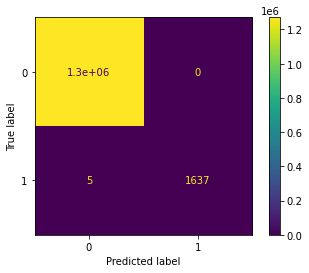

In [279]:
ConfusionMatrixDisplay(confusion_matrix(y_val,y_val_preds)).plot()

In [280]:
test_report

,0,1,accuracy,macro avg,weighted avg
precision,1.000000e+00,0.995739,0.999994,9.978693e-01,9.999945e-01
recall,9.999945e-01,1.000000,0.999994,9.999972e-01,9.999945e-01
f1-score,9.999972e-01,0.997865,0.999994,9.989310e-01,9.999945e-01
support,3.812665e+06,4907.000000,0.999994,3.817572e+06,3.817572e+06


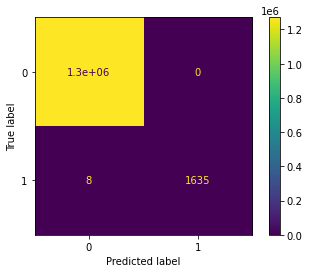

In [281]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_preds)).plot()

In [282]:
mask = df_train['isfraud'] == 1
mask2 = df_train['amount'] < df_train['oldbalanceorg']
test = df_train[mask&mask2]

In [283]:
test['amount'].value_counts()

10000000.00    79
42062.82        1
9585040.37      1
399045.08       1
Name: amount, dtype: int64